# A Hidden-Markov Modeling Approach to Creating Synthetic Streamflow Scenarios

In this notebook, we will be covering the basics of fitting a Hidden Markov Model-based synthetic streamflow generator for a single site in the Upper Colorado River Basin. First we will characterize the observed history in the basin from 1909-2013. Then we will fit a synthetic streamflow generator to the observed flows in the basin in order to create the stationary synthetic flows. Finally we will build a non-stationary version of the generator to create flows that could be representative of plausible future climate in the region. In order to test this, we place the flows in the context of CMIP5 projections.  

## Motivation

In the Western United States, and particularly the Colorado River Basin, recent studies have used tree-ring reconstructions to suggest that the megadrought that has been occurring in the Southwest over the past 22 years is the regions worst drought since about 800 AD (Williams et al., 2022). The study's lead author, UCLA climatologist Park Williams, suggested that had the sequence of wet-dry years occurred as observed but without the human-caused drying trend, the 2000s would have likely still been dry, but not on the same level as the worst of the last millennium’s megadroughts.

The recent trend of warming and reduced soil moisture in the SW is becoming extremely problematic from a water systems planning and management perspective for the Colorado River Basin. It has becoming rapidly clear that the river is completely over-allocated and won't be able to sustain flow requirements as dictated by the Colorado Compact. Thus, there has been an increasing focus in understanding how susceptible water systems in this region are to plausible future streamflow scenarios. In this tutorial, we'll discuss how to create these scenarios using a Hidden Markov Model (HMM)- based synthetic generator.

<figure>
<img src="1-lede_pix_-_usbr-powell-8517152024_aa66437c2e_o-cropped.jpg" style="width:50%">
<figcaption style="text-align:center"> Lake Powell shows persistent effects from drought (Source: U.S. Bureau of Reclamation) </figcaption>
</figure>


# Let's Get Started!

### Step 1: Observed Record

First let's take a look at the observed data from 1909-2013 for the outlet gauge of the Upper Colorado River. Below we create a plot of the annual streamflow.

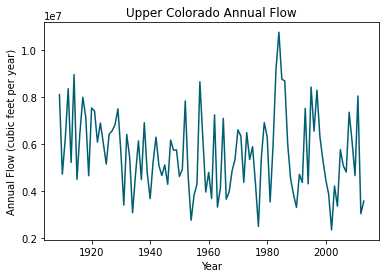

In [5]:
#Import libraries
import statistics 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.patches as patches
 
#Read in annual data
AnnualQ_h = pd.read_csv('E:/hmm_TA/uc_historical.csv')
AnnualQ_h['Year']=list(range(1909, 2014))

#Plot a line graph
plt.plot(AnnualQ_h.iloc[:,1],AnnualQ_h.iloc[:,0],color='#005F73')
# Add labels and title
plt.title("Upper Colorado Annual Flow")
plt.xlabel("Year")
plt.ylabel("Annual Flow (cubic feet per year)")
plt.savefig('observed.png',dpi=300)
plt.show()


Let's add a 10-year rolling mean to get a sense of long-term trends. 

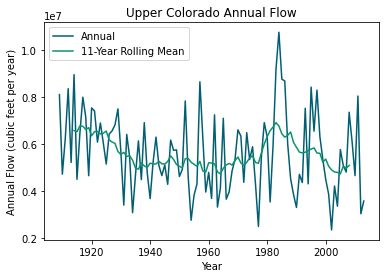

In [6]:
#Plot the original line graph
plt.plot(AnnualQ_h.iloc[:,1],AnnualQ_h.iloc[:,0],color='#005F73',label='Annual')
#Plot an 11-year rolling mean 
plt.plot(AnnualQ_h.iloc[:,1].rolling(11).mean(),AnnualQ_h.iloc[:,0].rolling(11).mean(),color='#0A9369',label='11-Year Rolling Mean')
# Add labels and title
plt.title("Upper Colorado Annual Flow")
plt.xlabel("Year")
plt.ylabel("Annual Flow (cubic feet per year)")
plt.legend() 
plt.savefig('observed_rolling_mean.png',dpi=300)
plt.show()

The Colorado Compact prescribing flows between the Upper and Lower Colorado Basins was negotiated using data prior to 1922, which we now know was one of the consistently wetter periods in the record. It's clear today that since the 1980s, the Southwest has been experiencing imminent arridification and that this observed record alone isn't an accurate representation of what future climate might look like in this region.

Let's get a little more specific and formally quantify decadal drought risk in the observed period. We use a metric proposed in Ault et al. (2014). The authors define a decadal drought, such as the 1930's dustbowl or 1950's drought in the Southwest as a streamflow value that is more than a half a standard deviation below the 11-year running mean of the available record.

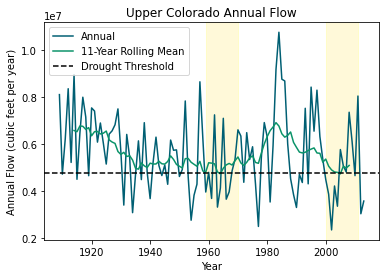

In [7]:
#Define drought threshold 
std=statistics.stdev(AnnualQ_h.iloc[:,0])
threshold=np.mean(AnnualQ_h.iloc[:,0]-(0.5*std))


#Where does the rolling mean dip below the threshold
drought_instances=[i for i,v in enumerate(AnnualQ_h.iloc[:,0].rolling(11).mean()) if v < threshold]
drought_years=AnnualQ_h.iloc[:,1].rolling(11).mean()[drought_instances]

fig, ax = plt.subplots()
ax.plot(AnnualQ_h.iloc[:,1],AnnualQ_h.iloc[:,0],color='#005F73',label='Annual') 
ax.plot(AnnualQ_h.iloc[:,1].rolling(11,center=True).mean(),AnnualQ_h.iloc[:,0].rolling(11,center=True).mean(),color='#0A9369',label='11-Year Rolling Mean')
ax.axhline(y=threshold, color='black', linestyle='--',label='Drought Threshold')

#Visualize the drought periods
for i in drought_years:
    #Plot a box centered around those values and with 5 years on either side.
    rect = patches.Rectangle((i-5,0), 11,2e7, linewidth=1, edgecolor='yellow', facecolor='gold',alpha=0.15)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    
plt.title("Upper Colorado Annual Flow")
plt.xlabel("Year")
plt.ylabel("Annual Flow (cubic feet per year)")
plt.savefig('observed_rolling_mean.png',dpi=300)
plt.legend() 
plt.show()

By this metric, the Upper Colorado Basin region has experienced two decadal droughts historically. 

### Step 2: Synthetic Stationary Generator to Understand Natural Variability

It is important to remember that streamflow that we have observed in the region is only one instance of what is an inherently stochastic system. We require a tool that will allow us to see multiple plausible realizations of that same variability. The tool that we use to develop synthetic flows for the region is a Gaussian Hidden Markov Model (HMM). If a system follows a Markov process, it switches between a number of “hidden states” dictated by a transition matrix. Each state has its own Gaussian probability distribution (defined by a mean and standard deviation) and one can draw from this distribution to create synthetic flows that fit the properties of the historical distribution. HMMs are an attractive choice for this region because they can simulate long persistence, particularly long droughts, which is characteristic of the region. The figure below shows an example of a 2-state Gaussian HMM that we will be fitting for this example.

<figure>
<img src="HMM_example.png" style="width:50%">
<figcaption style="text-align:center"> Two-state Gaussian HMM with mean and standard deviation parameters</figcaption>
</figure>


Below is the code that fits the HMM model to log annual flows at the CO- UT stateline gauge and creates an alternative trace of 105 years.

In [8]:
#Import libraries 
from hmmlearn.hmm import GaussianHMM
#Read in the historical data
AnnualQ = pd.read_csv('E:/hmm_TA/uc_historical.csv')

def fitHMM(Q, nSamples):
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=2, n_iter=1000).fit(np.reshape(Q[35::],[len(Q[35::]),1]))
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(np.reshape(Q,[len(Q),1]))
 
    # find parameters of Gaussian HMM
    mus = np.array(model.means_)
    sigmas = np.array(np.sqrt(np.array([np.diag(model.covars_[0]),np.diag(model.covars_[1])])))
    P = np.array(model.transmat_)
 
    # find log-likelihood of Gaussian HMM
    logProb = model.score(np.reshape(Q,[len(Q),1]))
 
    # generate nSamples from Gaussian HMM
    samples = model.sample(nSamples)
 
    # re-organize mus, sigmas and P so that first row is lower mean (if not already)
    if mus[0] > mus[1]:
        mus = np.flipud(mus)
        sigmas = np.flipud(sigmas)
        P = np.fliplr(np.flipud(P))
        hidden_states = 1 - hidden_states
 
    return hidden_states, mus, sigmas, P, logProb, samples, model


#Fit and sample from the model 
logQ = np.log(AnnualQ)
hidden_states, mus, sigmas, P, logProb, samples, model = fitHMM(logQ,105)


We've fit our HMM, but what does the model look like? Let’s plot the annual time series of hidden states, or the Viterbi sequence. In the code, above, we have defined that the drier state is always represented by state 0. Thus, we know that hidden_states = 0 corresponds to the dry state and hidden_states = 1 to the wet state.

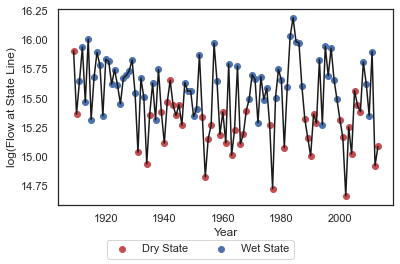

In [21]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

AnnualQ = pd.read_csv('E:/hmm_TA/uc_historical.csv')
AnnualQ['Year']=list(range(1909, 2014))
 
def plotTimeSeries(Q, hidden_states, ylabel):
 
    sns.set_theme(style='white')
    fig = plt.figure()
    ax = fig.add_subplot(111)
 
    xs = np.arange(len(Q))+1909
    masks = hidden_states == 0
    ax.scatter(xs[masks], Q[masks], c='r', label='Dry State')
    masks = hidden_states == 1
    ax.scatter(xs[masks], Q[masks], c='b', label='Wet State')
    ax.plot(xs, Q, c='k')
     
    ax.set_xlabel('Year')
    ax.set_ylabel(ylabel)
    fig.subplots_adjust(bottom=0.2)
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, frameon=True)
 
    return None
 
plotTimeSeries(np.log(AnnualQ.iloc[:,0]), hidden_states, 'log(Flow at State Line)')


We can also print the transition matrix, which shows the likelihood of transitioning between states. Note that the system has a high likelihood of persisting in the same state.

In [9]:
print(model.transmat_)

[[0.6794469  0.3205531 ]
 [0.34904974 0.65095026]]


Let's also plot the distribution of the wet and dry state.

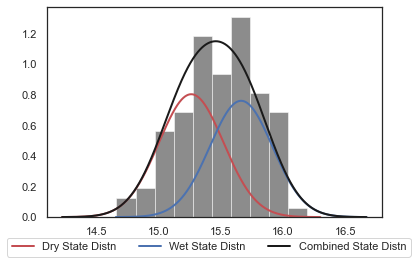

In [13]:
from scipy import stats as ss

def plotDistribution(Q, mus, sigmas, P):
 
    # calculate stationary distribution
    eigenvals, eigenvecs = np.linalg.eig(np.transpose(P))
    one_eigval = np.argmin(np.abs(eigenvals-1))
    pi = eigenvecs[:,one_eigval] / np.sum(eigenvecs[:,one_eigval])
 
    x_0 = np.linspace(mus[0]-4*sigmas[0], mus[0]+4*sigmas[0], 10000)
    fx_0 = pi[0]*ss.norm.pdf(x_0,mus[0],sigmas[0])
 
    x_1 = np.linspace(mus[1]-4*sigmas[1], mus[1]+4*sigmas[1], 10000)
    fx_1 = pi[1]*ss.norm.pdf(x_1,mus[1],sigmas[1])
 
    x = np.linspace(mus[0]-4*sigmas[0], mus[1]+4*sigmas[1], 10000)
    fx = pi[0]*ss.norm.pdf(x,mus[0],sigmas[0]) + \
        pi[1]*ss.norm.pdf(x,mus[1],sigmas[1])
 
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(Q, color='k', alpha=0.5, density=True)
    l1, = ax.plot(x_0, fx_0, c='r', linewidth=2, label='Dry State Distn')
    l2, = ax.plot(x_1, fx_1, c='b', linewidth=2, label='Wet State Distn')
    l3, = ax.plot(x, fx, c='k', linewidth=2, label='Combined State Distn')
 
    fig.subplots_adjust(bottom=0.15)
    handles, labels = plt.gca().get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=3, frameon=True)
    return None
 
plotDistribution(logQ, mus, sigmas, P)

The wet state distribution is characterized by a greater mean flow, but note that there is significant overlap in the tails of the distributions below which demonstrates why years with similiar flows can be classified in different states. 

Now let's see what the drought dynamics look like in the synthetic scenario that we created.

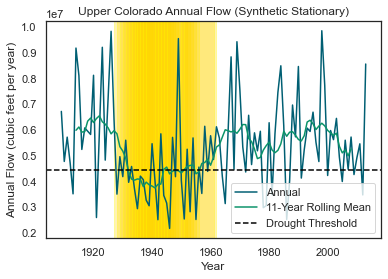

In [31]:
#Retrieve samples and back-transform out of log space
AnnualQ_s=np.exp(samples[0])
AnnualQ_s=pd.DataFrame(AnnualQ_s)
AnnualQ_s['Year']=list(range(1909, 2014))

#Define drought threshold 
std=statistics.stdev(AnnualQ_s.iloc[:,0])
threshold=np.mean(AnnualQ_s.iloc[:,0]-(0.5*std))


#Where does the rolling mean dip below the threshold
drought_instances=[i for i,v in enumerate(AnnualQ_s.iloc[:,0].rolling(11).mean()) if v < threshold]
drought_years=AnnualQ_s.iloc[:,1].rolling(11).mean()[drought_instances]


#Visualize the streamflow scenario
fig, ax = plt.subplots()
#Plot the original line graph
ax.plot(AnnualQ_s.iloc[:,1],AnnualQ_s.iloc[:,0],color='#005F73',label='Annual')
#Plot a 10-year rolling mean 
ax.plot(AnnualQ_s.iloc[:,1],AnnualQ_s.iloc[:,0].rolling(11,center=True).mean(),color='#0A9369',label='11-Year Rolling Mean')
# Add labels and title
ax.axhline(y=threshold, color='black', linestyle='--',label='Drought Threshold')


for i in drought_years:
    #Plot a box centered around those values and with 5 years on either side.
    rect = patches.Rectangle((i-5,0), 11,2e7, linewidth=1, edgecolor='yellow', facecolor='gold',alpha=0.3)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    
plt.title("Upper Colorado Annual Flow (Synthetic Stationary)")
plt.xlabel("Year")
plt.ylabel("Annual Flow (cubic feet per year)")
plt.legend() 
plt.savefig('synthetic_stationary.png',dpi=300)
plt.show()

You can sample from the model and create more 105-year traces and note how the location and number of decadal droughts changes. This demonstrates how different the historical record can look just within the range of natural variability. It's also important to remember that when droughts occur can also define the ultimate effect of the drought (i.e. is it at a time when there is a large population growth or a time when humans can adapt by conserving or building more infrastructure?). A hydrologic drought need not manifest into an agricultural drought of the same magnitude if stored surface water is available. 

### Step 3: Non-Stationary Synthetic Generator to Impose Climate Changes

Now, we want to be able to create flows under non-stationary conditions to get a better understanding of what flows can look like under climate changes. In order to create flows under non-stationary conditions, we can toggle the parameters of the HMM model in order to create systematic changes to the model that can represent a changing climate. The HMM has 6 parameters that define it. In the historical distribution, we fit a baseline value for these parameters. In this non-stationary generator, we define a range to sample these parameters from.

| Parameter | Current Value | Lower Bound | Upper Bound |
| :- | -: | :-: | :-: |
| Log-Space Wet State Mean Multiplier |1.00|0.98|1.02|
| Log-Space Dry State Mean Multiplier |1.00|0.98|1.02|
| Log-Space Wet State Standard Deviation Multiplier |1.00|0.75|1.25|
| Log-Space Dry State Standard Deviation Multiplier |1.00|0.75|1.25|
| Change in Dry-Dry Transition Probability |0.00|-0.30|+0.30|
| Change in Wet-Wet Transition Probability |0.00|-0.30|+0.30|


Now let's sample 1000 times from these bounds. Here we use SALib and the LHS sample function. 

In [9]:
from SALib.sample import latin
problem = {
    'num_vars': 6,
    'names': ['wet_mu', 'dry_mu', 'wet_std','dry_std','dry_tp',"wet_tp"],
    'bounds': [[0.98, 1.02],
               [0.98, 1.02],
               [0.75,1.25],
               [0.75,1.25],
               [-0.3,0.3],
               [-0.3,0.3]]
}

# generate 1000 parameterizations
n_samples = 1000

# set random seed for reproducibility
seed_value = 123

# generate our samples and view what it looks like
LHsamples = latin.sample(problem, n_samples, seed_value)

LHsamples

array([[ 1.00636632,  0.98299672,  0.88738223,  0.89362649, -0.18796839,
        -0.08374226],
       [ 0.99220589,  1.00242586,  1.24525332,  0.75976077,  0.08253608,
         0.25862735],
       [ 1.0132144 ,  0.98746233,  0.95654836,  0.83021612,  0.15100197,
        -0.01622897],
       ...,
       [ 0.98289054,  0.99699345,  1.04339644,  0.88611135, -0.07777507,
         0.29293043],
       [ 0.99570243,  1.00237363,  1.13207072,  1.08650267,  0.10654772,
         0.00289819],
       [ 1.00134951,  0.99886009,  1.14619391,  0.9171715 , -0.07029954,
        -0.1652552 ]])

Now let's look at what some of the traces look like in our non-stationary generator. Let's choose a random instance from the 1000-member space and adjust the parameters accordingly.

In [14]:
from random import random
from scipy import stats as ss


#Define static parameters 
nYears=105
sample=215

# create empty arrays to store the new Gaussian HMM parameters for each SOW
Pnew = np.empty([2,2])
piNew = np.empty([2])
musNew_HMM = np.empty([2])
sigmasNew_HMM = np.empty([2])
logAnnualQ_s = np.empty([nYears]) 

# Calculate new transition matrix and stationary distribution of SOW at last node
# as well as new means and standard deviations

Pnew[0,0] = max(0.0,min(1.0,P[0,0]+LHsamples[sample][4]))
Pnew[1,1] = max(0.0,min(1.0,P[1,1]+LHsamples[sample][5]))
Pnew[0,1] = 1 - Pnew[0,0]
Pnew[1,0] = 1 - Pnew[1,1]
eigenvals, eigenvecs = np.linalg.eig(np.transpose(Pnew))
one_eigval = np.argmin(np.abs(eigenvals-1))
piNew = np.dot(np.transpose(Pnew),eigenvecs[:,one_eigval]) / \
    np.sum(np.dot(np.transpose(Pnew),eigenvecs[:,one_eigval]))

musNew_HMM[0] = mus[0] * LHsamples[sample][1]
musNew_HMM[1] = mus[1] * LHsamples[sample][0]
sigmasNew_HMM[0] = sigmas[0] * LHsamples[sample][3]
sigmasNew_HMM[1] = sigmas[1] * LHsamples[sample][2]

# generate first state and log-space annual flow at last node
states = np.empty([nYears])
if random() <= piNew[0]:
    states[0] = 0
    logAnnualQ_s[0] = ss.norm.rvs(musNew_HMM[0], sigmasNew_HMM[0])
else:
    states[0] = 1
    logAnnualQ_s[0] = ss.norm.rvs(musNew_HMM[1], sigmasNew_HMM[1])

# generate remaining state trajectory and log space flows at last node
for j in range(1,nYears):
    if random() <= Pnew[int(states[j-1]),int(states[j-1])]:
        states[j] = states[j-1]
    else:
        states[j] = 1 - states[j-1]

    if states[j] == 0:
        logAnnualQ_s[j] = ss.norm.rvs(musNew_HMM[0], sigmasNew_HMM[0])
    else:
        logAnnualQ_s[j] = ss.norm.rvs(musNew_HMM[1], sigmasNew_HMM[1])

# convert log-space flows to real-space flows
AnnualQ_s = np.exp(logAnnualQ_s)-1

Now let's see what this synthetic trace looks like.

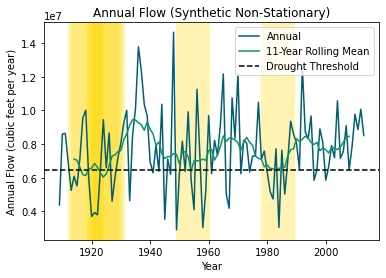

In [16]:
#Retrieve samples and back-transform out of log space
AnnualQ_s=pd.DataFrame(AnnualQ_s)
AnnualQ_s['Year']=list(range(1909, 2014))

#Define drought threshold 
std=statistics.stdev(AnnualQ_s.iloc[:,0])
threshold=np.mean(AnnualQ_s.iloc[:,0]-(0.5*std))


#Where does the rolling mean dip below the threshold
drought_instances=[i for i,v in enumerate(AnnualQ_s.iloc[:,0].rolling(11).mean()) if v < threshold]
drought_years=AnnualQ_s.iloc[:,1].rolling(11).mean()[drought_instances]


#Visualize the streamflow scenario
fig, ax = plt.subplots()
#Plot the original line graph
ax.plot(AnnualQ_s.iloc[:,1],AnnualQ_s.iloc[:,0],color='#005F73',label='Annual')
#Plot a 10-year rolling mean 
ax.plot(AnnualQ_s.iloc[:,1],AnnualQ_s.iloc[:,0].rolling(11,center=True).mean(),color='#0A9369',label='11-Year Rolling Mean')
# Add labels and title
ax.axhline(y=threshold, color='black', linestyle='--',label='Drought Threshold')


for i in drought_years:
    #Plot a box centered around those values and with 5 years on either side.
    rect = patches.Rectangle((i-5,0), 11,2e7, linewidth=1, edgecolor='yellow', facecolor='gold',alpha=0.3)
    # Add the patch to the Axes
    ax.add_patch(rect)
    
    
plt.title("Annual Flow (Synthetic Non-Stationary)")
plt.xlabel("Year")
plt.ylabel("Annual Flow (cubic feet per year)")
plt.legend() 
plt.savefig('non_synthetic_stationary.png',dpi=300)
plt.show()

Now let's summarize decadal drought dynamics across all the samples. Let's plot a histogram of the total number of decadal droughts across these realizations.

In [17]:
decadal_drought_occurence=np.empty([1000]) 

for y in range(1000):
    # create empty arrays to store the new Gaussian HMM parameters for each SOW
    Pnew = np.empty([2,2])
    piNew = np.empty([2])
    musNew_HMM = np.empty([2])
    sigmasNew_HMM = np.empty([2])
    logAnnualQ_s = np.empty([nYears]) 

    #Define static parameters 
    nYears=105
    # Calculate new transition matrix and stationary distribution of SOW at last node
    # as well as new means and standard deviations

    Pnew[0,0] = max(0.0,min(1.0,P[0,0]+LHsamples[y][4]))
    Pnew[1,1] = max(0.0,min(1.0,P[1,1]+LHsamples[y][5]))
    Pnew[0,1] = 1 - Pnew[0,0]
    Pnew[1,0] = 1 - Pnew[1,1]
    eigenvals, eigenvecs = np.linalg.eig(np.transpose(Pnew))
    one_eigval = np.argmin(np.abs(eigenvals-1))
    piNew = np.dot(np.transpose(Pnew),eigenvecs[:,one_eigval]) / \
        np.sum(np.dot(np.transpose(Pnew),eigenvecs[:,one_eigval]))

    musNew_HMM[0] = mus[0] * LHsamples[y][1]
    musNew_HMM[1] = mus[1] * LHsamples[y][0]
    sigmasNew_HMM[0] = sigmas[0] * LHsamples[y][3]
    sigmasNew_HMM[1] = sigmas[1] * LHsamples[y][2]

    # generate first state and log-space annual flow at last node
    states = np.empty([nYears])
    if random() <= piNew[0]:
        states[0] = 0
        logAnnualQ_s[0] = ss.norm.rvs(musNew_HMM[0], sigmasNew_HMM[0])
    else:
        states[0] = 1
        logAnnualQ_s[0] = ss.norm.rvs(musNew_HMM[1], sigmasNew_HMM[1])

    # generate remaining state trajectory and log space flows at last node
    for j in range(1,nYears):
        if random() <= Pnew[int(states[j-1]),int(states[j-1])]:
            states[j] = states[j-1]
        else:
            states[j] = 1 - states[j-1]

        if states[j] == 0:
            logAnnualQ_s[j] = ss.norm.rvs(musNew_HMM[0], sigmasNew_HMM[0])
        else:
            logAnnualQ_s[j] = ss.norm.rvs(musNew_HMM[1], sigmasNew_HMM[1])

    # convert log-space flows to real-space flows
    AnnualQ_s = np.exp(logAnnualQ_s)-1
    AnnualQ_s=pd.DataFrame(AnnualQ_s)
    AnnualQ_s['Year']=list(range(1909, 2014))

    #Define drought threshold 
    std=statistics.stdev(AnnualQ_s.iloc[:,0])
    threshold=np.mean(AnnualQ_s.iloc[:,0]-(0.5*std))


    #Where does the rolling mean dip below the threshold
    drought_instances=[i for i,v in enumerate(AnnualQ_s.iloc[:,0].rolling(11).mean()) if v < threshold]
    decadal_drought_occurence[y]=len(drought_instances)
    

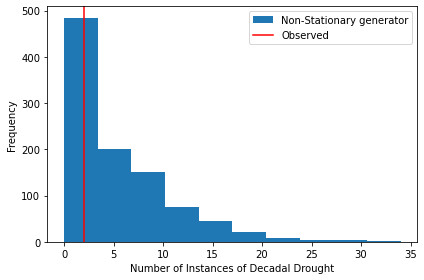

In [19]:
fig, ax = plt.subplots()
ax.hist(decadal_drought_occurence,label='Non-Stationary generator')
ax.set_xlabel('Number of Instances of Decadal Drought')
ax.set_ylabel('Frequency')
ax.axvline(x=2, color='r', linestyle='-',label='Observed')
plt.legend()
fig.tight_layout()
plt.savefig('histogram.png',dpi=300)
plt.show()

Note how many more instances of the decadal droughts we are creating with the non-stationary generator than our observed 105-year trace.

### Step 4: Placing Non-Stationary Flows in the Context of CMIP5 Projections

We have broadened the drought conditions that we are creating which that can be very useful to understand how our water systems model performs under potentially extreme scenarios. However, it's useful to place our synthetically generated flows in the context of physically-driven CIMP5 projections to get a better understanding of how the two approaches compare. This example makes use of 97 CMIP5 projections used in the Colorado River Water Availability Study (CWCB, 2012). In each of these projections, monthly precipitation factor changes and temperature delta changes were computed between mean projected 2035–2065 climate statistics and mean historical climate statistics from 1950–2013. These 97 different combinations of 12 monthly precipitation multipliers and 12 monthly temperature delta shifts were applied to historical precipitation and temperature time series from 1950–2013. The resulting climate time series were run through a Variable Infiltration Capacity (VIC) model of the UCRB, resulting in 97 time series of projected future streamflows at the Colorado‐Utah state line.

We fit the HMM to each trace of projected streamflow and calculate the new HMM parameters. Then we take the ratio between these parameters and the baseline HMM parameters in order to calculate the multipliers. This is all done externally and then we import the multipliers on the next line:

In [20]:
#Read in CMIP5 and paleo multipliers
import statsmodels.api as sm
CMIP5_multipliers = pd.read_csv('E:/hmm_TA/CMIP5_SOWs.txt',header=None,sep=" ")
paleo_multipliers = pd.read_csv('E:/hmm_TA/Paleo_SOWs.txt',header=None,sep=" ")

Let's plot a response surface that will allow us to see which combination of HMM parameters tend to influence decadal drought. In order to get a continuous surface, we'll fit a non-linear regression fit to the parameter values and then predict the decadal drought over a set of grid points. 

In [23]:
mu_dry=[i[1] for i in LHsamples]
tp_dry=[i[4] for i in LHsamples]

xgrid = np.arange(np.min(mu_dry),
                  np.max(mu_dry), (np.max(mu_dry)-np.min(mu_dry))/100)
ygrid = np.arange(np.min(tp_dry),
                  np.max(tp_dry), (np.max(tp_dry)-np.min(tp_dry))/100)

#Fit regression 
d = {'Dry_Tp': tp_dry, 'Dry_Mu': mu_dry,'Drought_Occurrence':decadal_drought_occurence}
d=pd.DataFrame(d)
d['Intercept'] = np.ones(np.shape(d)[0])
d['Interaction'] = d['Dry_Tp']*d['Dry_Mu']
cols = ['Intercept'] + ['Dry_Mu']+['Dry_Tp']+['Interaction']
ols = sm.OLS(d['Drought_Occurrence'], d[cols])
result = ols.fit()

X, Y = np.meshgrid(xgrid, ygrid)
x = X.flatten()
y = Y.flatten()
grid = np.column_stack([np.ones(len(x)),x,y,x*y])
z = result.predict(grid)
z[z<0.0] = 0.0 # replace negative shortage predictions with 0


Let's plot our results:

C:\Users\rg727\AppData\Local\Temp\ipykernel_11196\968757829.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


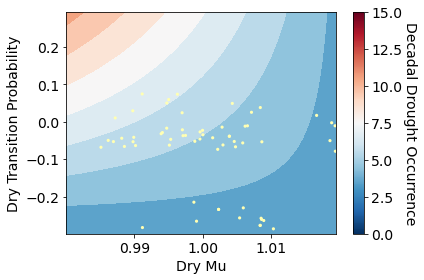

In [25]:
import matplotlib as mpl
drought_map = mpl.cm.get_cmap('RdBu_r')
Z = np.reshape(z, np.shape(X))

vmin = np.min([np.min(z),np.min(d['Drought_Occurrence'].values)])
vmax = 15
norm = mpl.colors.Normalize(vmin,vmax)

fig, ax = plt.subplots()
ax.contourf(X, Y, Z, cmap=drought_map, norm=norm)
#ax.scatter(paleo_multipliers.iloc[:,7], paleo_multipliers.iloc[:,12], c='#b3de69', edgecolor='none', s=10)
ax.scatter(CMIP5_multipliers.iloc[:,7],CMIP5_multipliers.iloc[:,12], c='#ffffb3', edgecolor='none', s=10)
#ax.scatter(d['Dry_Mu'],d['Dry_Tp'], c=d['Drought_Occurrence'], edgecolor='none', cmap=drought_map, norm=norm, s=10)
cbar = ax.figure.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=drought_map), ax=ax)
ax.set_xlim(np.nanmin(X),np.nanmax(X))
ax.set_ylim(np.nanmin(Y),np.nanmax(Y))
ax.set_xlabel('Dry Mu',fontsize=14)
ax.set_ylabel('Dry Transition Probability',fontsize=14)
ax.tick_params(axis='both',labelsize=14)
cbar.ax.set_ylabel('Decadal Drought Occurrence',rotation=-90, fontsize=14, labelpad=15)
cbar.ax.tick_params(axis='y',labelsize=14)
fig.tight_layout()
plt.savefig('decadal_drought.png',dpi=300)
fig.show()

We see the influence of the dry state mean and dry-dry transition parameters. We're likely to see more decadal droughts when we (1) increase the dry-dry transition probability, which inherently will increase persistence of the dry state, and (2) when we make the dry state log mean drier. Note that the climate change scenarios tend to span the extent of the dry mean sample space, but are less representative of the dry transition probability sample space, which suggests that the types of hydrological droughts represented in the projections tend to only be wetter to slightly drier than our baseline.

### Tips to Create an HMM-Based Generator for your Problem

In this tutorial, we demonstrated how to fit an HMM-based generator for a single gauge located in the Upper Colorado River Basin. In order to apply this methodology to your problem, you will need to have daily and annual data for your location of interest. We have applied this style of generator to locations where persistent wet and dry states are characteristic, which tends to be in the Western US. The HMM is fit to log annual flows and then ultimately can be disaggregated to daily flows (using your daily dataset) to be useful in water resources application. Ultimately the best way to judge if an HMM is useful for your application is to fit the model and explore the distributions. Are there two (or more) distinct states that emerge? If not, then an HMM-based generator may not be appropriate and you can explore other styles of generators such as the Kirsch-Nowak generator.